# 回归

In [21]:
from pathlib import Path
import sys
import os
root_dir = str(Path(os.getcwd()).parent)
sys.path.append(root_dir)

import pandas as pd
import datetime
import numpy as np
import statsmodels.api as sm
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from report.evaluate.regression import get_interval_rets, reg
from report.util import get_trade_date
from statsmodels.iolib.summary2 import summary_col

In [2]:
factor_data_tech = pq.read_table(f'{root_dir}/data/intermediate_results/factor_data_tech.parquet').to_pandas()
trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
factor_data_fundamentall =  pq.read_table(f'{root_dir}/data/intermediate_results/factor_data_fundamentall.parquet').to_pandas()
yysj_pro = pq.read_table(f'{root_dir}/data/intermediate_results/yysj_pro.parquet').to_pandas()
stk_info = pq.read_table(f'{root_dir}/data/intermediate_results/stk_info.parquet').to_pandas()

factor_data_tech = pd.merge(left=trade_date_lag, right=factor_data_tech, on=['stock_symbol', 'trade_date'], how='left')

In [3]:
index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
index_data = index_data.loc[index_data['stock_symbol']=='000001']
index_data = pd.merge(left=trade_date_lag, right=index_data.drop(columns=['stock_symbol']), on=['trade_date'], how='left')
index_data

,stock_symbol,report_type,trade_date,lag,close,rets
0,000001,20061231,2007-02-01,-30,2785.432,-0.000324
1,000002,20061231,2007-01-30,-30,2930.562,-0.004991
2,000004,20061231,2007-03-16,-30,2930.481,-0.007188
3,000006,20061231,2007-02-05,-30,2612.537,-0.022697
4,000007,20061231,2007-03-09,-30,2937.910,0.003379
...,...,...,...,...,...,...
12782728,688799,20240930,2024-12-10,30,3422.661,0.005915
12782729,688800,20240930,2024-12-06,30,3404.076,0.010455
12782730,688819,20240930,2024-12-11,30,3432.490,0.002872
12782731,688981,20240930,2024-12-20,30,NaN,NaN


## 主回归

### 事前

In [6]:
reg_data = pd.merge(left=factor_data_tech, right=factor_data_fundamentall.drop(columns=['report_type']), left_on=['stock_symbol', 'report_type'], right_on=['stock_symbol', 'report_type_lag1'], how='left')
reg_data['bm'] = reg_data['asset'] / reg_data['market_cap']

reg_data = pd.merge(left=reg_data, right=yysj_pro, on=['stock_symbol', 'report_type'], how='left')
reg_data = pd.merge(left=reg_data, right=stk_info[['stock_symbol','listed_date']], on=['stock_symbol'], how='left')
reg_data.to_parquet(f'{root_dir}/data/reg_data/reg_data.parquet')
reg_data

,stock_symbol,report_type,trade_date,lag,state,rets1,rets2,close,pre_close,volume,...,asset,equity,net_profit,basic_earnings_per_share,size,roe,ue,ia,report_type_lag1,bm
0,000001,20061231,2007-02-01,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,2.876586e+11,7.106094e+09,5.350837e+08,0.270,26.385040,0.075299,NaN,0.184639,20061231,NaN
1,000002,20061231,2007-01-30,-30,1.0,-0.062673,-0.062673,16.90,18.03,91582843.0,...,5.017858e+10,1.795121e+10,6.161089e+08,0.140,24.638854,0.034321,NaN,0.746689,20061231,776.856683
2,000004,20061231,2007-03-16,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,1.837967e+08,1.051257e+08,5.068695e+05,0.001,19.029341,0.004822,NaN,-0.380771,20061231,NaN
3,000006,20061231,2007-02-05,-30,1.0,0.010714,0.010714,11.32,11.20,6013728.0,...,3.264881e+09,1.386697e+09,1.340063e+07,0.050,21.906489,0.009664,NaN,0.362139,20061231,1137.328676
4,000007,20061231,2007-03-09,-30,1.0,0.057644,0.057644,4.22,3.99,12979270.0,...,7.502672e+08,-1.679358e+07,-1.144691e+07,-0.050,20.435940,0.681624,NaN,-0.147582,20061231,961.198500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12782728,688799,20240930,2024-12-10,30,1.0,-0.007729,-0.007729,41.08,41.40,1265099.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12782729,688800,20240930,2024-12-06,30,1.0,-0.032621,-0.032621,42.11,43.53,5025279.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12782730,688819,20240930,2024-12-11,30,1.0,0.009672,0.009672,29.23,28.95,2574608.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12782731,688981,20240930,2024-12-20,30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
reg_data.columns

Index(['stock_symbol', 'report_type', 'trade_date', 'lag', 'state', 'rets1',
       'rets2', 'close', 'pre_close', 'volume', 'amount', 'float_market_cap',
       'market_cap', 'turnonver', 'vol5', 'volt20', 'mtm', 'asset', 'equity',
       'net_profit', 'basic_earnings_per_share', 'size', 'roe', 'ue', 'ia',
       'report_type_lag1', 'bm', 'type', 'book_time_rank_first',
       'book_time_rank_last', 'report_time_rank_last', 'days_to_startline',
       'days_to_deadline', 'listed_date'],
      dtype='object')

In [13]:
reg_data1 = reg_data.loc[(reg_data['lag']==-10) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['state'] == 1) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data1 = pd.merge(left=reg_data1, right=get_interval_rets(-10, -1, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data1 = pd.merge(left=reg_data1, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data1

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets-10_-1_x,rets-10_-1_y
0,000002,20061231,2007-03-06,-10,0.247843,24.638854,858.657812,0.034321,0.746689,-0.058498,1.218996,0.909073,0.083061,0.061358
1,000006,20061231,2007-03-12,-10,0.309804,21.906489,940.435397,0.009664,0.362139,0.052267,2.937024,0.784582,0.088386,0.040398
2,000007,20061231,2007-04-06,-10,0.734118,20.435940,771.151646,0.681624,-0.147582,-0.016822,11.220742,0.350201,0.142586,0.037740
3,000008,20061231,2007-03-15,-10,0.396863,18.223267,151.218560,0.013152,0.057776,0.204248,9.328794,0.466267,0.024423,0.074981
4,000012,20061231,2007-03-06,-10,0.247843,22.646248,888.027956,-0.006525,0.138707,-0.000735,2.634069,0.969929,0.000000,0.061358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158692,688798,20240930,2024-10-16,-10,0.529481,NaN,NaN,NaN,NaN,0.520749,0.471817,12.217570,0.045533,0.026057
158693,688799,20240930,2024-10-15,-10,0.355142,NaN,NaN,NaN,NaN,0.082448,0.277372,3.817362,0.028505,0.037768
158694,688800,20240930,2024-10-11,-10,0.100686,NaN,NaN,NaN,NaN,0.552141,2.064280,5.595555,0.395975,0.019431
158695,688819,20240930,2024-10-16,-10,0.529481,NaN,NaN,NaN,NaN,0.136037,0.137049,3.466183,0.018957,0.026057


In [15]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets-10_-1_x']
reg(reg_data1, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5961.
Date:                Sun, 22 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:04:10   Log-Likelihood:             1.6477e+05
No. Observations:              152852   AIC:                        -3.295e+05
Df Residuals:                  152842   BIC:                        -3.294e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0136      0.003      3.920      0.000       0.007       0.020
book_time_rank_first    -0.0197      0.001    -22.772      0.000      -0.021      -0.018
rets-10_-1_y             1.1981      0.005    225.513      0.000       1.188       1.209
size                    -0.0001      0.000     -0.783      0.434      -0.000       0.000
bm                    8.029e-08   2.74e-08      2.935      0.003    2.67e-08    1.34e-07
roe                      0.0009      0.000      2.896      0.004       0.000       0.002
ia                     7.36e-05   4.79e-05      1.537      0.124   -2.03e-05       0.000
vol5                    -0.0013   6.91e-05    -18.765      0.000      -0.001      -0.001
mtm                     -0.0025      0.002     -1.226      0.220      -0.007       0.002
volt20                  -0.0006      0.000     -5.252      0.000      -0.001      -0.000
==============================================================================
Omnibus:                    60443.251   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2030306.546
Skew:                           1.261   Prob(JB):                         0.00
Kurtosis:                      20.676   Cond. No.                     2.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:


df = reg_data2.dropna()
Y = df[y]
X = df[x]
X = sm.add_constant(X)
res_ols1 = sm.OLS(Y, X).fit()

res_ols1.summary()

summary_col([res_ols1],
             model_names = ['f1'],
             stars = True,regressor_order = ['const','pb','mktcap','mom1','roe_ttm'],
              info_dict = {'':lambda x: '',
                                                 '':lambda x: '',
                                                 'Observation':lambda x:str(int(x.nobs)),
                                                 })

,f1
const,0.0605***
,(0.0035)
book_time_rank_first,0.0088***
,(0.0009)
rets1_10_y,1.1783***
,(0.0058)
size,-0.0026***
,(0.0002)
bm,0.0000***
,(0.0000)


In [6]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data1, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5809.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:15:24   Log-Likelihood:             1.6181e+05
No. Observations:              148987   AIC:                        -3.236e+05
Df Residuals:                  148977   BIC:                        -3.235e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0564      0.005     12.081      0.000       0.047       0.066
book_time_rank_first       -0.0304      0.001    -35.343      0.000      -0.032      -0.029
rets-10_-1_y                1.0700      0.005    221.068      0.000       1.061       1.080
ln_assets                  -0.0020      0.000     -9.536      0.000      -0.002      -0.002
book_to_market_ratio_lf     0.0050      0.001      6.681      0.000       0.004       0.006
roe                         0.0001   8.25e-05      1.401      0.161   -4.61e-05       0.000
ia                          0.0002      0.000      1.170      0.242      -0.000       0.000
VOL5                     -8.96e-05   3.01e-05     -2.981      0.003      -0.000   -3.07e-05
MTM                     -5.482e-05   5.56e-05     -0.985      0.324      -0.000    5.42e-05
VOLT20                      0.0003      0.000      2.520      0.012    7.57e-05       0.001
==============================================================================
Omnibus:                    70383.086   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1659236.894
Skew:                           1.752   Prob(JB):                         0.00
Kurtosis:                      18.969   Cond. No.                         528.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 事后

In [17]:
reg_data_after = pd.merge(left=factor_data_tech, right=factor_data_fundamentall, on=['stock_symbol', 'report_type'], how='left')
reg_data_after['bm'] = reg_data_after['asset'] / reg_data_after['market_cap']

reg_data_after = pd.merge(left=reg_data_after, right=yysj_pro, on=['stock_symbol', 'report_type'], how='left')
reg_data_after = pd.merge(left=reg_data_after, right=stk_info[['stock_symbol','listed_date']], on=['stock_symbol'], how='left')
reg_data_after.to_parquet(f'{root_dir}/data/reg_data/reg_data_after.parquet')
reg_data_after

,stock_symbol,report_type,trade_date,lag,state,rets1,rets2,close,pre_close,volume,...,ia,report_type_lag1,bm,type,book_time_rank_first,book_time_rank_last,report_time_rank_last,days_to_startline,days_to_deadline,listed_date
0,000001,20061231,2007-02-01,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.172053,20060930,NaN,1231,0.280000,0.280000,0.280784,80.0,39.0,1991-04-03
1,000002,20061231,2007-01-30,-30,1.0,-0.062673,-0.062673,16.90,18.03,91582843.0,...,1.205668,20060930,750.991758,1231,0.247843,0.247843,0.247843,78.0,41.0,1991-01-29
2,000004,20061231,2007-03-16,-30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310748,20060930,NaN,1231,0.873725,0.873725,0.874510,116.0,3.0,1991-01-14
3,000006,20061231,2007-02-05,-30,1.0,0.010714,0.010714,11.32,11.20,6013728.0,...,0.143299,20060930,1016.814300,1231,0.309804,0.309804,0.309804,82.0,37.0,1992-04-27
4,000007,20061231,2007-03-09,-30,1.0,0.057644,0.057644,4.22,3.99,12979270.0,...,-0.056668,20060930,1032.443318,1231,0.734118,0.734118,0.737255,109.0,10.0,1992-04-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12782728,688799,20240930,2024-12-10,30,1.0,-0.007729,-0.007729,41.08,41.40,1265099.0,...,0.121729,20240630,617.644683,0930,0.355142,0.350833,0.350833,28.0,2.0,2021-07-13
12782729,688800,20240930,2024-12-06,30,1.0,-0.032621,-0.032621,42.11,43.53,5025279.0,...,0.194174,20240630,588.431755,0930,0.100686,0.100881,0.100881,24.0,6.0,2021-07-22
12782730,688819,20240930,2024-12-11,30,1.0,0.009672,0.009672,29.23,28.95,2574608.0,...,0.123769,20240630,1599.417774,0930,0.529481,0.526543,0.526543,29.0,1.0,2021-01-18
12782731,688981,20240930,2024-12-20,30,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.014099,20240630,NaN,0930,0.999412,0.999412,0.999412,38.0,-8.0,2020-07-16


In [18]:
reg_data2 = reg_data.loc[(reg_data_after['lag']==1) & 
    					 (reg_data_after['days_to_deadline']>0) & 
                         (reg_data_after['state'] == 1) &
                         (reg_data_after['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'size', 'bm', 'roe', 'ia', 'mtm', 'vol5', 'volt20']]

reg_data2 = pd.merge(left=reg_data2, right=get_interval_rets(1, 10, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data2 = pd.merge(left=reg_data2, right=get_interval_rets(1, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data2

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,size,bm,roe,ia,mtm,vol5,volt20,rets1_10_x,rets1_10_y
0,000002,20061231,2007-03-21,1,0.247843,24.638854,771.379433,0.034321,0.746689,0.090327,1.484217,0.906401,0.038778,0.076510
1,000006,20061231,2007-03-27,1,0.309804,21.906489,885.458089,0.009664,0.362139,0.033404,3.716892,0.681643,0.024759,0.082873
2,000012,20061231,2007-03-21,1,0.247843,22.646248,825.465110,-0.006525,0.138707,0.057887,1.910325,0.555242,0.036936,0.076510
3,000014,20061231,2007-04-25,1,0.809412,20.728070,595.885615,-0.010847,0.062044,0.040664,7.534441,0.638761,0.036683,0.041459
4,000016,20061231,2007-04-20,1,0.718431,22.959883,2711.439499,0.007014,0.112461,0.193103,7.960747,0.505953,0.091329,0.129875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159023,688798,20240930,2024-10-31,1,0.529481,NaN,NaN,NaN,NaN,0.089165,0.427718,5.109783,0.083021,0.048617
159024,688799,20240930,2024-10-30,1,0.355142,NaN,NaN,NaN,NaN,-0.042830,0.570325,2.652995,0.049691,0.047679
159025,688800,20240930,2024-10-28,1,0.100686,NaN,NaN,NaN,NaN,0.234685,1.149747,8.349320,-0.025147,0.039161
159026,688819,20240930,2024-10-31,1,0.529481,NaN,NaN,NaN,NaN,-0.048434,0.164296,2.056410,0.065151,0.048617


In [20]:
x = ['book_time_rank_first', 'rets1_10_y', 'size', 'bm', 'roe', 'ia', 'vol5', 'mtm', 'volt20']
y = ['rets1_10_x']
reg(reg_data2, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     4721.
Date:                Sun, 22 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:11:15   Log-Likelihood:             1.6342e+05
No. Observations:              153651   AIC:                        -3.268e+05
Df Residuals:                  153641   BIC:                        -3.267e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0605      0.004     17.245      0.000       0.054       0.067
book_time_rank_first     0.0088      0.001     10.113      0.000       0.007       0.011
rets1_10_y               1.1783      0.006    204.709      0.000       1.167       1.190
size                    -0.0026      0.000    -16.394      0.000      -0.003      -0.002
bm                    1.092e-07   2.77e-08      3.946      0.000     5.5e-08    1.63e-07
roe                     -0.0003      0.000     -1.000      0.317      -0.001       0.000
ia                   -6.839e-05   3.81e-05     -1.797      0.072      -0.000     6.2e-06
vol5                  1.789e-05      7e-05      0.256      0.798      -0.000       0.000
mtm                     -0.0211      0.002    -10.853      0.000      -0.025      -0.017
volt20                  -0.0010      0.000     -9.069      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    55181.266   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1487733.512
Skew:                           1.148   Prob(JB):                         0.00
Kurtosis:                      18.070   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
reg_data2 = reg_data.loc[(reg_data['lag']==1) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['is_suspended'] == False) &
                         (reg_data['is_st'] == False) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20']]

reg_data2 = pd.merge(left=reg_data2, right=get_interval_rets(1, 10, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data2 = pd.merge(left=reg_data2, right=get_interval_rets(1, 10, index_data), on=['stock_symbol', 'report_type'], how='left')
reg_data2

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,VOL5,VOLT20,rets1_10_x,rets1_10_y
0,000001,20061231,2007-03-23,1,0.280156,24.353192,0.171691,0.075299,0.103152,1.87,11.367868,0.159402,0.029920,0.084225
1,000002,20061231,2007-03-21,1,0.248249,25.032395,0.200097,0.034321,0.005183,3.01,8.278628,0.267324,0.038797,0.068644
2,000006,20061231,2007-03-27,1,0.309728,22.028139,0.345414,0.009664,0.122922,1.00,37.261283,0.100165,0.024752,0.091288
3,000009,20061231,2007-04-19,1,0.684825,22.876203,0.160723,0.038625,0.030145,1.48,86.260955,0.054059,0.289528,0.174896
4,000012,20061231,2007-03-21,1,0.248249,23.421001,0.177040,0.023285,0.009593,0.12,8.552355,0.172847,0.036932,0.068644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152860,605003,20240630,2024-07-31,1,0.480769,21.307156,0.780997,NaN,NaN,0.18,0.686436,0.240952,NaN,NaN
152861,688018,20240630,2024-07-31,1,0.480769,23.226947,0.158055,NaN,NaN,5.43,2.381848,5.250342,NaN,NaN
152862,688100,20240630,2024-07-31,1,0.480769,23.706926,0.152150,NaN,NaN,3.85,0.215379,1.158874,NaN,NaN
152863,688510,20240630,2024-07-26,1,0.153846,22.233866,0.235216,NaN,NaN,0.82,1.571669,0.409157,NaN,NaN


In [8]:
x = ['book_time_rank_first', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data2, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     4534.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:15:41   Log-Likelihood:             1.6170e+05
No. Observations:              149270   AIC:                        -3.234e+05
Df Residuals:                  149260   BIC:                        -3.233e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1392      0.005     29.950      0.000       0.130       0.148
book_time_rank_first        0.0082      0.001      9.496      0.000       0.006       0.010
rets1_10_y                  1.0531      0.005    197.467      0.000       1.043       1.064
ln_assets                  -0.0061      0.000    -29.783      0.000      -0.007      -0.006
book_to_market_ratio_lf     0.0087      0.001     11.852      0.000       0.007       0.010
roe                     -1.344e-05   8.28e-05     -0.162      0.871      -0.000       0.000
ia                          0.0001      0.000      0.885      0.376      -0.000       0.000
VOL5                    -8.431e-06   2.78e-05     -0.304      0.761   -6.29e-05     4.6e-05
MTM                        -0.0003   4.86e-05     -5.966      0.000      -0.000      -0.000
VOLT20                      0.0007      0.000      5.447      0.000       0.000       0.001
==============================================================================
Omnibus:                    70605.310   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1400924.771
Skew:                           1.808   Prob(JB):                         0.00
Kurtosis:                      17.566   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 机制检验

### 时间公布时的反应

In [9]:
trade_date = get_trade_date()
trade_date.set_index('trade_date', inplace=True)
trade_date.index = pd.to_datetime(trade_date.index)
trade_date['report_type'] = trade_date.index.to_period('Q')
trade_date = trade_date.reset_index()

quarter_date_list = []
for lag in [-5, -1, 1, 5]:
	quarter_date_lag = trade_date.groupby('report_type').nth(lag)
	quarter_date_lag['lag'] = lag
	if lag < 0:
		quarter_date_lag['report_type'] = quarter_date_lag['report_type'] + 1
	quarter_date_list.append(quarter_date_lag)
quarter_date = pd.concat(quarter_date_list)
quarter_date = quarter_date.sort_values(by='trade_date').reset_index(drop=True)
quarter_date['report_type'] = quarter_date['report_type'].apply(lambda x: str(x.end_time.strftime('%Y%m%d')))
quarter_date['trade_date'] = quarter_date['trade_date'].dt.date
quarter_date

,trade_date,report_type,lag
0,2004-08-10,20040930,1
1,2004-08-16,20040930,5
2,2004-09-24,20041231,-5
3,2004-09-30,20041231,-1
4,2004-10-11,20041231,1
...,...,...,...
335,2025-06-30,20250930,-1
336,2025-07-02,20250930,1
337,2025-07-08,20250930,5
338,2025-08-04,20251231,-5


In [10]:
quarter_reg_data = pd.merge(left=quarter_date, right=yysj_pro, on=['report_type'])
quarter_reg_data = pd.merge(left=quarter_reg_data, right=factor_data, how='left', on=['stock_symbol', 'trade_date'])
quarter_reg_data = pd.merge(left=quarter_reg_data, right=report_data.drop(columns='report_type'), left_on=['stock_symbol', 'report_type'], right_on=['stock_symbol', 'report_type_lag1'], how='left')
quarter_reg_data

,trade_date,report_type,lag,stock_symbol,book_time_rank_first,book_time_rank_last,report_time_rank_last,days_to_deadline,market_cap_3,book_to_market_ratio_lf,...,net_profit,total_assets,total_equity,basic_earnings_per_share,roa,roe,ia,eps_lag1,ue,report_type_lag1
0,2006-09-25,20061231,-5,000001,0.280156,0.280156,0.280934,39,1.476879e+10,0.378639,...,5.350840e+08,2.876586e+11,7.106094e+09,0.2600,0.001860,0.075299,0.103152,0.6800,-0.4200,20061231
1,2006-09-25,20061231,-5,000002,0.248249,0.248249,0.248249,41,3.001243e+10,0.346619,...,6.161089e+08,5.017858e+10,1.795121e+10,0.0930,0.012278,0.034321,0.005183,0.3900,-0.2970,20061231
2,2006-09-25,20061231,-5,000004,0.874708,0.874708,0.875486,3,3.249898e+08,0.254644,...,5.068695e+05,1.837967e+08,1.051257e+08,0.0012,0.002758,0.004822,-0.080145,0.0083,-0.0071,20061231
3,2006-09-25,20061231,-5,000006,0.309728,0.309728,0.309728,37,2.218927e+09,0.554167,...,1.340063e+07,3.264881e+09,1.386697e+09,0.0500,0.004104,0.009664,0.122922,0.8528,-0.8028,20061231
4,2006-09-25,20061231,-5,000007,0.734630,0.734630,0.737743,10,4.864589e+08,0.150455,...,-1.144691e+07,7.502672e+08,-1.679358e+07,-0.0525,-0.015257,0.681624,-0.039944,-0.6633,0.6108,20061231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794735,2024-04-10,20240630,5,688018,0.480769,0.557692,0.557692,31,7.503750e+09,0.254939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794736,2024-04-10,20240630,5,688027,0.980769,0.557692,0.557692,-1,1.350289e+10,0.111423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794737,2024-04-10,20240630,5,688100,0.480769,0.557692,0.557692,31,1.703000e+10,0.172408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794738,2024-04-10,20240630,5,688510,0.153846,0.096154,0.096154,36,4.439013e+09,0.236300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
quarter_index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
quarter_index_data = quarter_index_data.loc[quarter_index_data['stock_symbol']=='000300'].sort_values(by='trade_date')
quarter_index_data = pd.merge(left=quarter_date, right=quarter_index_data[['stock_symbol', 'trade_date', 'close']], on=['trade_date'], how='left')
quarter_index_data = quarter_index_data.dropna()
quarter_index_data

,trade_date,report_type,lag,stock_symbol,close
24,2006-01-05,20060331,1,000300,959.1340
25,2006-01-11,20060331,5,000300,973.4770
26,2006-03-27,20060630,-5,000300,1045.7930
27,2006-03-31,20060630,-1,000300,1061.0880
28,2006-04-04,20060630,1,000300,1089.3710
...,...,...,...,...,...
317,2024-04-10,20240630,5,000300,3504.7086
318,2024-06-24,20240930,-5,000300,3476.8102
319,2024-06-28,20240930,-1,000300,3461.6570
320,2024-07-02,20240930,1,000300,3471.7857


In [12]:
reg_data3 = quarter_reg_data.loc[(quarter_reg_data['lag']==-5) & 
    					 (quarter_reg_data['days_to_deadline']>0) & 
                         (quarter_reg_data['is_suspended'] == False) &
                         (quarter_reg_data['is_st'] == False) &
                         (quarter_reg_data['trade_date'] >= (quarter_reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20']]

reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(-5, -1, quarter_reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(-5, -1, quarter_index_data).drop(columns='stock_symbol'), on='report_type', how='left')

reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(-5, 5, quarter_reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(-5, 5, quarter_index_data).drop(columns='stock_symbol'), on='report_type', how='left')

reg_data3

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,VOL5,VOLT20,rets-5_-1_x,rets-5_-1_y,rets-5_5_x,rets-5_5_y
0,000001,20061231,2006-09-25,-5,0.280156,23.415782,0.378639,0.075299,0.103152,NaN,NaN,NaN,0.075146,0.022491,0.164704,0.033604
1,000002,20061231,2006-09-25,-5,0.248249,24.124878,0.346619,0.034321,0.005183,NaN,NaN,NaN,0.001324,0.022491,-0.059484,0.033604
2,000006,20061231,2006-09-25,-5,0.309728,21.520289,0.554167,0.009664,0.122922,NaN,NaN,NaN,-0.015944,0.022491,-0.025104,0.033604
3,000007,20061231,2006-09-25,-5,0.734630,20.002663,0.150455,0.681624,-0.039944,NaN,NaN,NaN,0.026635,0.022491,0.007643,0.033604
4,000008,20061231,2006-09-25,-5,0.396109,19.660311,0.209815,0.013152,0.068287,NaN,NaN,NaN,-0.004153,0.022491,0.023405,0.033604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147721,603737,20240630,2024-03-25,-5,0.346154,23.625142,0.157987,NaN,NaN,-2.77,0.706670,1.408816,-0.073808,0.003324,-0.087990,-0.005972
147722,605003,20240630,2024-03-25,-5,0.480769,21.326598,0.625016,NaN,NaN,0.51,0.598667,0.571816,0.025877,0.003324,0.046936,-0.005972
147723,688018,20240630,2024-03-25,-5,0.480769,22.798229,0.240198,NaN,NaN,1.28,1.450262,2.028322,-0.056299,0.003324,-0.057822,-0.005972
147724,688100,20240630,2024-03-25,-5,0.480769,23.574261,0.169668,NaN,NaN,1.01,0.578073,1.939303,-0.000290,0.003324,-0.015892,-0.005972


In [13]:
x = ['book_time_rank_first', 'rets-5_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-5_-1_x']
reg(reg_data3, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rets-5_-1_x   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     3048.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:16:13   Log-Likelihood:             2.1585e+05
No. Observations:              142303   AIC:                        -4.317e+05
Df Residuals:                  142293   BIC:                        -4.316e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0530      0.003    -17.093      0.000      -0.059      -0.047
book_time_rank_first       -0.0039      0.001     -6.899      0.000      -0.005      -0.003
rets-5_-1_y                 1.0196      0.006    161.500      0.000       1.007       1.032
ln_assets                   0.0022      0.000     15.678      0.000       0.002       0.002
book_to_market_ratio_lf    -0.0002      0.001     -0.404      0.686      -0.001       0.001
roe                      4.483e-05    5.2e-05      0.863      0.388    -5.7e-05       0.000
ia                       8.882e-05   9.47e-05      0.938      0.348   -9.68e-05       0.000
VOL5                       -0.0004   1.95e-05    -21.233      0.000      -0.000      -0.000
MTM                      9.495e-05   3.92e-05      2.424      0.015    1.82e-05       0.000
VOLT20                     -0.0003   9.21e-05     -3.171      0.002      -0.000      -0.000
==============================================================================
Omnibus:                    38279.412   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           369250.967
Skew:                           1.019   Prob(JB):                         0.00
Kurtosis:                      10.624   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
x = ['book_time_rank_first', 'rets-5_5_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-5_5_x']
reg(reg_data3, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets-5_5_x   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     6942.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:16:13   Log-Likelihood:             1.3937e+05
No. Observations:              142303   AIC:                        -2.787e+05
Df Residuals:                  142293   BIC:                        -2.786e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0083      0.005      1.567      0.117      -0.002       0.019
book_time_rank_first       -0.0029      0.001     -3.018      0.003      -0.005      -0.001
rets-5_5_y                  1.0787      0.004    247.661      0.000       1.070       1.087
ln_assets                  -0.0007      0.000     -2.939      0.003      -0.001      -0.000
book_to_market_ratio_lf     0.0077      0.001      9.006      0.000       0.006       0.009
roe                      1.937e-06   8.89e-05      0.022      0.983      -0.000       0.000
ia                         -0.0001      0.000     -0.867      0.386      -0.000       0.000
VOL5                       -0.0003   3.34e-05     -8.036      0.000      -0.000      -0.000
MTM                         0.0002    6.7e-05      2.608      0.009    4.35e-05       0.000
VOLT20                     -0.0010      0.000     -6.440      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    47771.002   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           683415.676
Skew:                           1.220   Prob(JB):                         0.00
Kurtosis:                      13.455   Cond. No.                         510.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
reg_data3 = quarter_reg_data.loc[(quarter_reg_data['lag']==1) & 
    					 (quarter_reg_data['days_to_deadline']>0) & 
                         (quarter_reg_data['is_suspended'] == False) &
                         (quarter_reg_data['is_st'] == False) &
                         (quarter_reg_data['trade_date'] >= (quarter_reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20']]

reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(1, 5, quarter_reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data3 = pd.merge(left=reg_data3, right=get_interval_rets(1, 5, quarter_index_data).drop(columns='stock_symbol'), on='report_type', how='left')

reg_data3

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,VOL5,VOLT20,rets1_5_x,rets1_5_y
0,000002,20061231,2006-10-10,1,0.248249,24.070516,0.365983,0.034321,0.005183,NaN,NaN,NaN,-0.006935,-0.013030
1,000006,20061231,2006-10-10,1,0.309728,21.475890,0.579326,0.009664,0.122922,NaN,NaN,NaN,0.019151,-0.013030
2,000007,20061231,2006-10-10,1,0.734630,20.021496,0.147648,0.681624,-0.039944,NaN,NaN,NaN,-0.011194,-0.013030
3,000008,20061231,2006-10-10,1,0.396109,19.681409,0.205435,0.013152,0.068287,NaN,NaN,NaN,0.002033,-0.013030
4,000009,20061231,2006-10-10,1,0.684825,22.116288,0.295229,0.038625,0.030145,NaN,NaN,NaN,0.000000,-0.013030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148255,603737,20240630,2024-04-02,1,0.346154,23.551902,0.169992,NaN,NaN,-7.59,0.920916,2.640598,-0.018686,-0.021216
148256,605003,20240630,2024-04-02,1,0.480769,21.375903,0.594947,NaN,NaN,0.47,0.753959,0.427163,-0.003435,-0.021216
148257,688018,20240630,2024-04-02,1,0.480769,22.753311,0.251233,NaN,NaN,-2.93,1.387985,2.017868,-0.014536,-0.021216
148258,688100,20240630,2024-04-02,1,0.480769,23.557067,0.172611,NaN,NaN,-1.44,0.498876,1.065325,0.001176,-0.021216


In [16]:
x = ['book_time_rank_first', 'rets1_5_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_5_x']
reg(reg_data3, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rets1_5_x   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     7637.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:16:15   Log-Likelihood:             2.0477e+05
No. Observations:              143702   AIC:                        -4.095e+05
Df Residuals:                  143692   BIC:                        -4.094e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0183      0.003      5.420      0.000       0.012       0.025
book_time_rank_first       -0.0009      0.001     -1.392      0.164      -0.002       0.000
rets1_5_y                   1.2319      0.005    257.074      0.000       1.223       1.241
ln_assets                  -0.0010      0.000     -6.397      0.000      -0.001      -0.001
book_to_market_ratio_lf     0.0034      0.001      6.155      0.000       0.002       0.004
roe                      3.481e-05   5.69e-05      0.611      0.541   -7.68e-05       0.000
ia                         -0.0002      0.000     -2.401      0.016      -0.000   -4.58e-05
VOL5                       -0.0001   2.32e-05     -4.680      0.000      -0.000   -6.32e-05
MTM                         0.0006    3.5e-05     15.799      0.000       0.000       0.001
VOLT20                     -0.0006      0.000     -6.362      0.000      -0.001      -0.000
==============================================================================
Omnibus:                    33494.514   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           273112.907
Skew:                           0.898   Prob(JB):                         0.00
Kurtosis:                       9.510   Cond. No.                         719.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 好消息早

In [17]:
reg_data.columns

Index(['stock_symbol', 'report_type', 'trade_date', 'lag',
       'book_time_rank_first', 'book_time_rank_last', 'report_time_rank_last',
       'days_to_deadline', 'market_cap_3', 'book_to_market_ratio_lf',
       'du_return_on_equity_ttm', 'VOL5', 'MTM', 'VOLT20', 'VOLT10',
       'total_assets_mrq_0', 'return_on_asset_ttm', 'DAVOL5', 'prev_close',
       'total_turnover', 'num_trades', 'high', 'close', 'limit_up', 'low',
       'volume', 'limit_down', 'open', 'is_suspended', 'is_st',
       'circulation_a', 'non_circulation_a', 'total_a', 'free_circulation',
       'preferred_shares', 'total', 'listed_date', 'ln_assets',
       'total_liabilities', 'net_profit', 'total_assets', 'total_equity',
       'basic_earnings_per_share', 'roa', 'roe', 'ia', 'eps_lag1', 'ue',
       'report_type_lag1', 'bias', 'count', 'fprofit', 'eps', 'feps_std',
       'feps_mean', 'disp'],
      dtype='object')

In [35]:
reg_data4 = reg_data.loc[(reg_data['lag']==-10) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['is_suspended'] == False) &
                         (reg_data['is_st'] == False) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'ue', 'close', 'bias', 'market_cap_3', 'fprofit', 'net_profit']]

reg_data4['ue'] = reg_data4['ue'] / reg_data4['close']
reg_data4['ue1'] = (reg_data4['net_profit'] - reg_data4['fprofit']) / reg_data4['market_cap_3']
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,...,VOLT20,ue,close,bias,market_cap_3,fprofit,net_profit,ue1,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,...,0.253528,-0.110985,3.7843,0.524020,3.677604e+10,NaN,5.350840e+08,NaN,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,...,0.268112,-0.077783,3.8183,0.339316,6.681575e+10,NaN,6.161089e+08,NaN,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,...,0.115292,-0.435169,1.8448,0.064259,3.471669e+09,NaN,1.340063e+07,NaN,0.088411,0.038260
3,000007,20061231,2007-04-06,-10,0.734630,20.695810,0.065745,0.681624,-0.039944,0.79,...,0.233468,0.174181,3.5067,NaN,9.729178e+08,NaN,-1.144691e+07,NaN,0.142584,0.059991
4,000008,20061231,2007-03-15,-10,0.396109,20.112296,0.133207,0.013152,0.068287,0.82,...,0.052673,0.036032,0.8326,NaN,5.428241e+08,NaN,1.003699e+06,NaN,0.024381,0.057494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152598,605003,20240630,2024-07-16,-10,0.480769,21.301619,0.797826,NaN,NaN,-0.05,...,0.321028,NaN,16.2100,NaN,1.783100e+09,NaN,NaN,NaN,-0.004318,-0.030741
152599,688018,20240630,2024-07-16,-10,0.480769,23.245762,0.151087,NaN,NaN,28.53,...,9.454977,NaN,111.0600,NaN,1.245966e+10,NaN,NaN,NaN,-0.075815,-0.030741
152600,688100,20240630,2024-07-16,-10,0.480769,23.606669,0.158779,NaN,NaN,-1.71,...,1.156185,NaN,35.7500,NaN,1.787500e+10,NaN,NaN,NaN,-0.009231,-0.030741
152601,688510,20240630,2024-07-11,-10,0.153846,22.268623,0.230419,NaN,NaN,-0.29,...,0.643697,NaN,18.1500,NaN,4.689644e+09,NaN,NaN,NaN,0.006612,-0.014418


In [36]:
x = ['book_time_rank_first', 'ue', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     553.4
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:19:21   Log-Likelihood:                 24291.
No. Observations:               21842   AIC:                        -4.856e+04
Df Residuals:                   21831   BIC:                        -4.847e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0522      0.012      4.269      0.000       0.028       0.076
book_time_rank_first       -0.0556      0.002    -27.192      0.000      -0.060      -0.052
ue                         -0.0029      0.001     -2.310      0.021      -0.005      -0.000
rets-10_-1_y                1.1619      0.018     65.395      0.000       1.127       1.197
ln_assets                  -0.0012      0.001     -2.286      0.022      -0.002      -0.000
book_to_market_ratio_lf    -0.0002      0.002     -0.096      0.923      -0.003       0.003
roe                         0.0302      0.005      6.576      0.000       0.021       0.039
ia                          0.0039      0.002      2.403      0.016       0.001       0.007
VOL5                       -0.0013      0.000     -9.044      0.000      -0.002      -0.001
MTM                         0.0005      0.000      3.967      0.000       0.000       0.001
VOLT20                      0.0008      0.000      2.941      0.003       0.000       0.001
==============================================================================
Omnibus:                     9661.310   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159453.913
Skew:                           1.702   Prob(JB):                         0.00
Kurtosis:                      15.792   Cond. No.                         766.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
x = ['book_time_rank_first', 'ue1', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     557.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:19:30   Log-Likelihood:                 24306.
No. Observations:               21842   AIC:                        -4.859e+04
Df Residuals:                   21831   BIC:                        -4.850e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0515      0.012      4.221      0.000       0.028       0.075
book_time_rank_first       -0.0556      0.002    -27.233      0.000      -0.060      -0.052
ue1                     -4.766e-06   8.07e-07     -5.905      0.000   -6.35e-06   -3.18e-06
rets-10_-1_y                1.1617      0.018     65.426      0.000       1.127       1.197
ln_assets                  -0.0012      0.001     -2.219      0.026      -0.002      -0.000
book_to_market_ratio_lf    -0.0003      0.002     -0.183      0.855      -0.004       0.003
roe                         0.0303      0.005      6.596      0.000       0.021       0.039
ia                          0.0039      0.002      2.402      0.016       0.001       0.007
VOL5                       -0.0013      0.000     -9.260      0.000      -0.002      -0.001
MTM                         0.0005      0.000      3.947      0.000       0.000       0.001
VOLT20                      0.0008      0.000      2.881      0.004       0.000       0.001
==============================================================================
Omnibus:                     9630.150   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158731.139
Skew:                           1.695   Prob(JB):                         0.00
Kurtosis:                      15.764   Cond. No.                     2.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
reg_data4 = reg_data.loc[(reg_data['lag']==1) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['is_suspended'] == False) &
                         (reg_data['is_st'] == False) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'market_cap_3', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'ue', 'close', 'bias', 'fprofit', 'net_profit']]

reg_data4['ue'] = reg_data4['ue'] / reg_data4['close']
reg_data4['ue1'] = (reg_data4['net_profit'] - reg_data4['fprofit']) / reg_data4['market_cap_3']
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,market_cap_3,book_to_market_ratio_lf,roe,ia,...,VOL5,VOLT20,ue,close,bias,fprofit,net_profit,ue1,rets1_10_x,rets1_10_y
0,000001,20061231,2007-03-23,1,0.280156,24.353192,3.771003e+10,0.171691,0.075299,0.103152,...,11.367868,0.159402,-0.108236,3.8804,0.524020,NaN,5.350840e+08,NaN,0.029920,0.084225
1,000002,20061231,2007-03-21,1,0.248249,25.032395,7.437568e+10,0.200097,0.034321,0.005183,...,8.278628,0.267324,-0.069877,4.2503,0.339316,NaN,6.161089e+08,NaN,0.038797,0.068644
2,000006,20061231,2007-03-27,1,0.309728,22.028139,3.687222e+09,0.345414,0.009664,0.122922,...,37.261283,0.100165,-0.409717,1.9594,0.064259,NaN,1.340063e+07,NaN,0.024752,0.091288
3,000009,20061231,2007-04-19,1,0.684825,22.876203,8.610114e+09,0.160723,0.038625,0.030145,...,86.260955,0.054059,-0.033021,2.8467,0.142857,NaN,8.246384e+07,NaN,0.289528,0.174896
4,000012,20061231,2007-03-21,1,0.248249,23.421001,1.484607e+10,0.177040,0.023285,0.009593,...,8.552355,0.172847,-0.068757,4.0723,0.671542,NaN,7.019879e+07,NaN,0.036932,0.068644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152860,605003,20240630,2024-07-31,1,0.480769,21.307156,1.793000e+09,0.780997,NaN,NaN,...,0.686436,0.240952,NaN,16.3000,NaN,NaN,NaN,NaN,NaN,NaN
152861,688018,20240630,2024-07-31,1,0.480769,23.226947,1.222743e+10,0.158055,NaN,NaN,...,2.381848,5.250342,NaN,108.9900,NaN,NaN,NaN,NaN,NaN,NaN
152862,688100,20240630,2024-07-31,1,0.480769,23.706926,1.976000e+10,0.152150,NaN,NaN,...,0.215379,1.158874,NaN,39.5200,NaN,NaN,NaN,NaN,NaN,NaN
152863,688510,20240630,2024-07-26,1,0.153846,22.233866,4.529447e+09,0.235216,NaN,NaN,...,1.571669,0.409157,NaN,17.5300,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
x = ['book_time_rank_first', 'ue', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     486.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:20:27   Log-Likelihood:                 23013.
No. Observations:               21861   AIC:                        -4.600e+04
Df Residuals:                   21850   BIC:                        -4.592e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0666      0.013      5.165      0.000       0.041       0.092
book_time_rank_first        0.0166      0.002      7.607      0.000       0.012       0.021
ue                          0.0010      0.001      0.798      0.425      -0.001       0.003
rets1_10_y                  1.2622      0.019     67.576      0.000       1.226       1.299
ln_assets                  -0.0033      0.001     -5.945      0.000      -0.004      -0.002
book_to_market_ratio_lf     0.0109      0.002      6.088      0.000       0.007       0.014
roe                         0.0185      0.005      3.763      0.000       0.009       0.028
ia                          0.0042      0.002      2.423      0.015       0.001       0.008
VOL5                       -0.0009      0.000     -6.041      0.000      -0.001      -0.001
MTM                        -0.0003      0.000     -3.110      0.002      -0.001      -0.000
VOLT20                      0.0012      0.000      4.250      0.000       0.001       0.002
==============================================================================
Omnibus:                    10368.918   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           217009.620
Skew:                           1.793   Prob(JB):                         0.00
Kurtosis:                      18.013   Cond. No.                         760.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
x = ['book_time_rank_first', 'ue1', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     486.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:20:27   Log-Likelihood:                 23013.
No. Observations:               21861   AIC:                        -4.600e+04
Df Residuals:                   21850   BIC:                        -4.592e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0667      0.013      5.177      0.000       0.041       0.092
book_time_rank_first        0.0166      0.002      7.614      0.000       0.012       0.021
ue1                      8.512e-07   1.08e-06      0.790      0.430   -1.26e-06    2.96e-06
rets1_10_y                  1.2621      0.019     67.575      0.000       1.226       1.299
ln_assets                  -0.0033      0.001     -5.960      0.000      -0.004      -0.002
book_to_market_ratio_lf     0.0109      0.002      6.095      0.000       0.007       0.014
roe                         0.0185      0.005      3.758      0.000       0.009       0.028
ia                          0.0042      0.002      2.424      0.015       0.001       0.008
VOL5                       -0.0009      0.000     -5.998      0.000      -0.001      -0.001
MTM                        -0.0003      0.000     -3.107      0.002      -0.001      -0.000
VOLT20                      0.0012      0.000      4.255      0.000       0.001       0.002
==============================================================================
Omnibus:                    10369.509   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           217061.095
Skew:                           1.793   Prob(JB):                         0.00
Kurtosis:                      18.014   Cond. No.                     1.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 交易量

In [41]:
reg_data4 = reg_data.loc[(reg_data['lag']==-10) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['is_suspended'] == False) &
                         (reg_data['is_st'] == False) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'DAVOL5']]

reg_data4['DAVOL5_rank'] = reg_data4.groupby('report_type')['DAVOL5'].rank(ascending=True, pct=True, method='min')
reg_data4.loc[reg_data4['DAVOL5_rank']>=0.8, 'd_high'] = 1
reg_data4.loc[reg_data4['DAVOL5_rank']<=0.2, 'd_low'] = 1
reg_data4['d_high'] = reg_data4['d_high'].fillna(0)
reg_data4['d_low'] = reg_data4['d_low'].fillna(0)

reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,...,total_a,net_profit,volume,circulation_a,DAVOL5,DAVOL5_rank,d_high,d_low,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,...,1.945822e+09,5.350840e+08,7.334840e+07,1.409362e+09,1.318859,0.406593,0.0,0.0,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,...,3.822001e+09,6.161089e+08,1.296845e+08,3.254271e+09,1.160933,0.075924,0.0,1.0,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,...,2.535916e+08,1.340063e+07,3.925960e+07,2.186029e+08,1.142066,0.056943,0.0,1.0,0.088411,0.038260
3,000007,20061231,2007-04-06,-10,0.734630,20.695810,0.065745,0.681624,-0.039944,0.79,...,1.849654e+08,-1.144691e+07,1.343641e+07,1.209327e+08,1.440206,0.726274,0.0,0.0,0.142584,0.059991
4,000008,20061231,2007-03-15,-10,0.396109,20.112296,0.133207,0.013152,0.068287,0.82,...,7.365321e+07,1.003699e+06,1.903524e+07,4.234860e+07,1.314811,0.399600,0.0,0.0,0.024381,0.057494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152598,605003,20240630,2024-07-16,-10,0.480769,21.301619,0.797826,NaN,NaN,-0.05,...,1.100000e+08,NaN,3.393000e+05,1.100000e+08,0.464856,0.276596,0.0,0.0,-0.004318,-0.030741
152599,688018,20240630,2024-07-16,-10,0.480769,23.245762,0.151087,NaN,NaN,28.53,...,1.121885e+08,NaN,3.117270e+06,1.121885e+08,1.180870,0.893617,1.0,0.0,-0.075815,-0.030741
152600,688100,20240630,2024-07-16,-10,0.480769,23.606669,0.158779,NaN,NaN,-1.71,...,5.000000e+08,NaN,8.351080e+05,5.000000e+08,0.392932,0.106383,0.0,1.0,-0.009231,-0.030741
152601,688510,20240630,2024-07-11,-10,0.153846,22.268623,0.230419,NaN,NaN,-0.29,...,2.583826e+08,NaN,2.350849e+06,2.583826e+08,0.665401,0.510638,0.0,0.0,0.006612,-0.014418


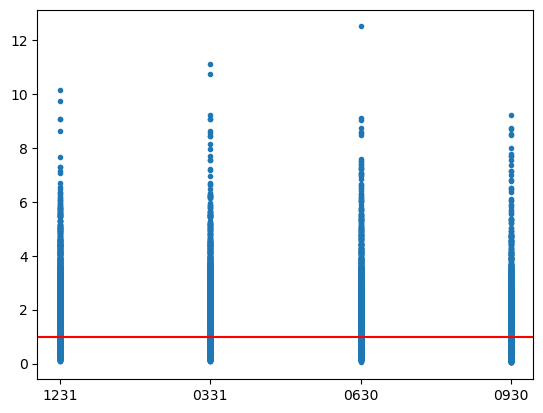

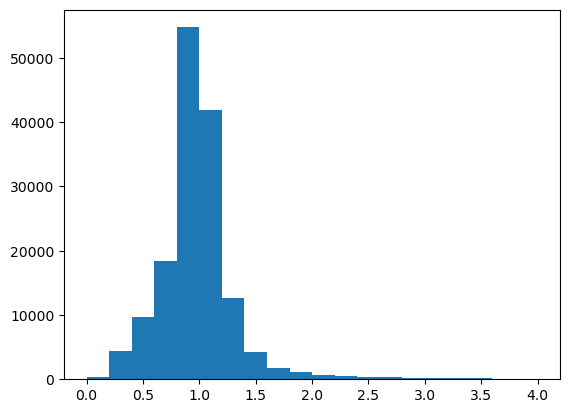

In [46]:
plt.axhline(1, color='red')
plt.scatter(reg_data4['report_type'].str[4:], reg_data4['DAVOL5'], marker='.')
plt.show()
plt.hist(reg_data4['DAVOL5'], bins=20, range=(0, 4))
plt.show()

In [26]:
x = ['book_time_rank_first', 'DAVOL5_rank', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5232.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:14   Log-Likelihood:             1.6182e+05
No. Observations:              148977   AIC:                        -3.236e+05
Df Residuals:                  148966   BIC:                        -3.235e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0546      0.005     11.664      0.000       0.045       0.064
book_time_rank_first       -0.0305      0.001    -35.454      0.000      -0.032      -0.029
DAVOL5_rank                -0.0049      0.001     -6.306      0.000      -0.006      -0.003
rets-10_-1_y                1.0680      0.005    220.193      0.000       1.059       1.078
ln_assets                  -0.0018      0.000     -8.536      0.000      -0.002      -0.001
book_to_market_ratio_lf     0.0047      0.001      6.265      0.000       0.003       0.006
roe                         0.0001   8.25e-05      1.426      0.154   -4.41e-05       0.000
ia                          0.0002      0.000      1.189      0.234      -0.000       0.000
VOL5                    -5.409e-05   3.06e-05     -1.770      0.077      -0.000     5.8e-06
MTM                      2.028e-06   5.64e-05      0.036      0.971      -0.000       0.000
VOLT20                      0.0004      0.000      2.806      0.005       0.000       0.001
==============================================================================
Omnibus:                    70655.435   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1669026.106
Skew:                           1.761   Prob(JB):                         0.00
Kurtosis:                      19.015   Cond. No.                         530.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
x = ['book_time_rank_first', 'd_high', 'd_low', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets-10_-1_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rets-10_-1_x   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     4756.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:14   Log-Likelihood:             1.6182e+05
No. Observations:              148977   AIC:                        -3.236e+05
Df Residuals:                  148965   BIC:                        -3.235e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0532      0.005     11.301      0.000       0.044       0.062
book_time_rank_first       -0.0305      0.001    -35.465      0.000      -0.032      -0.029
d_high                     -0.0032      0.001     -5.596      0.000      -0.004      -0.002
d_low                       0.0008      0.001      1.458      0.145      -0.000       0.002
rets-10_-1_y                1.0684      0.005    220.373      0.000       1.059       1.078
ln_assets                  -0.0018      0.000     -8.670      0.000      -0.002      -0.001
book_to_market_ratio_lf     0.0046      0.001      6.136      0.000       0.003       0.006
roe                         0.0001   8.25e-05      1.408      0.159   -4.55e-05       0.000
ia                          0.0002      0.000      1.193      0.233      -0.000       0.000
VOL5                    -5.479e-05   3.05e-05     -1.793      0.073      -0.000    5.09e-06
MTM                      1.383e-06   5.64e-05      0.025      0.980      -0.000       0.000
VOLT20                      0.0004      0.000      2.832      0.005       0.000       0.001
==============================================================================
Omnibus:                    70679.352   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1669854.979
Skew:                           1.761   Prob(JB):                         0.00
Kurtosis:                      19.019   Cond. No.                         530.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
reg_data4 = reg_data.loc[(reg_data['lag']==1) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['is_suspended'] == False) &
                         (reg_data['is_st'] == False) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'DAVOL5']]

reg_data4['DAVOL5_rank'] = reg_data4.groupby('report_type')['DAVOL5'].rank(ascending=True, pct=True, method='min')
reg_data4.loc[reg_data4['DAVOL5_rank']>=0.8, 'd_high'] = 1
reg_data4.loc[reg_data4['DAVOL5_rank']<=0.2, 'd_low'] = 1
reg_data4['d_high'] = reg_data4['d_high'].fillna(0)
reg_data4['d_low'] = reg_data4['d_low'].fillna(0)

reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data4 = pd.merge(left=reg_data4, right=get_interval_rets(1, 10, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data4

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,market_cap_3,book_to_market_ratio_lf,roe,ia,MTM,...,net_profit,volume,circulation_a,DAVOL5,ln_assets,DAVOL5_rank,d_high,d_low,rets1_10_x,rets1_10_y
0,000001,20061231,2007-03-23,1,0.280156,3.771003e+10,0.171691,0.075299,0.103152,1.87,...,5.350840e+08,1.417865e+08,1.409362e+09,1.356491,24.353192,0.392675,0.0,0.0,0.029920,0.084225
1,000002,20061231,2007-03-21,1,0.248249,7.437568e+10,0.200097,0.034321,0.005183,3.01,...,6.161089e+08,1.864575e+08,3.254271e+09,1.223021,25.032395,0.109868,0.0,1.0,0.038797,0.068644
2,000006,20061231,2007-03-27,1,0.309728,3.687222e+09,0.345414,0.009664,0.122922,1.00,...,1.340063e+07,5.309325e+07,2.186029e+08,1.185449,22.028139,0.060020,0.0,1.0,0.024752,0.091288
3,000009,20061231,2007-04-19,1,0.684825,8.610114e+09,0.160723,0.038625,0.030145,1.48,...,8.246384e+07,9.363616e+07,5.797268e+08,1.587583,22.876203,0.858596,1.0,0.0,0.289528,0.174896
4,000012,20061231,2007-03-21,1,0.248249,1.484607e+10,0.177040,0.023285,0.009593,0.12,...,7.019879e+07,2.811287e+07,2.176773e+08,1.304594,23.421001,0.267548,0.0,0.0,0.036932,0.068644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152860,605003,20240630,2024-07-31,1,0.480769,1.793000e+09,0.780997,NaN,NaN,0.18,...,NaN,1.341375e+06,1.100000e+08,0.579962,21.307156,0.250000,0.0,0.0,NaN,NaN
152861,688018,20240630,2024-07-31,1,0.480769,1.222743e+10,0.158055,NaN,NaN,5.43,...,NaN,3.361250e+06,1.121885e+08,1.100126,23.226947,0.772727,0.0,0.0,NaN,NaN
152862,688100,20240630,2024-07-31,1,0.480769,1.976000e+10,0.152150,NaN,NaN,3.85,...,NaN,2.370254e+06,5.000000e+08,0.431809,23.706926,0.159091,0.0,1.0,NaN,NaN
152863,688510,20240630,2024-07-26,1,0.153846,4.529447e+09,0.235216,NaN,NaN,0.82,...,NaN,3.532993e+06,2.583826e+08,1.224694,22.233866,0.886364,1.0,0.0,NaN,NaN


In [29]:
x = ['book_time_rank_first', 'DAVOL5_rank', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     4099.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:32   Log-Likelihood:             1.6177e+05
No. Observations:              149264   AIC:                        -3.235e+05
Df Residuals:                  149253   BIC:                        -3.234e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1362      0.005     29.281      0.000       0.127       0.145
book_time_rank_first        0.0075      0.001      8.687      0.000       0.006       0.009
DAVOL5_rank                -0.0092      0.001    -11.972      0.000      -0.011      -0.008
rets1_10_y                  1.0500      0.005    196.771      0.000       1.040       1.061
ln_assets                  -0.0058      0.000    -27.847      0.000      -0.006      -0.005
book_to_market_ratio_lf     0.0083      0.001     11.214      0.000       0.007       0.010
roe                     -1.162e-05   8.28e-05     -0.140      0.888      -0.000       0.000
ia                          0.0001      0.000      0.924      0.355      -0.000       0.000
VOL5                     5.297e-05   2.82e-05      1.877      0.060   -2.33e-06       0.000
MTM                        -0.0002   4.91e-05     -4.178      0.000      -0.000      -0.000
VOLT20                      0.0008      0.000      6.111      0.000       0.001       0.001
==============================================================================
Omnibus:                    71167.410   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1417388.046
Skew:                           1.827   Prob(JB):                         0.00
Kurtosis:                      17.647   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
x = ['book_time_rank_first', 'd_high', 'd_low', 'rets1_10_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['rets1_10_x']
reg(reg_data4, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rets1_10_x   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     3725.
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:17:32   Log-Likelihood:             1.6177e+05
No. Observations:              149264   AIC:                        -3.235e+05
Df Residuals:                  149252   BIC:                        -3.234e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1326      0.005     28.317      0.000       0.123       0.142
book_time_rank_first        0.0076      0.001      8.846      0.000       0.006       0.009
d_high                     -0.0038      0.001     -6.699      0.000      -0.005      -0.003
d_low                       0.0042      0.001      7.602      0.000       0.003       0.005
rets1_10_y                  1.0507      0.005    196.945      0.000       1.040       1.061
ln_assets                  -0.0058      0.000    -28.130      0.000      -0.006      -0.005
book_to_market_ratio_lf     0.0084      0.001     11.330      0.000       0.007       0.010
roe                     -1.318e-05   8.28e-05     -0.159      0.874      -0.000       0.000
ia                          0.0001      0.000      0.935      0.350      -0.000       0.000
VOL5                     4.361e-05   2.82e-05      1.546      0.122   -1.17e-05    9.89e-05
MTM                        -0.0002   4.91e-05     -4.399      0.000      -0.000      -0.000
VOLT20                      0.0008      0.000      6.023      0.000       0.001       0.001
==============================================================================
Omnibus:                    71069.631   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1414712.856
Skew:                           1.824   Prob(JB):                         0.00
Kurtosis:                      17.634   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 分析师学习行为

In [31]:
reg_data5 = reg_data.loc[(reg_data['lag']==-10) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['is_suspended'] == False) &
                         (reg_data['is_st'] == False) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'disp', 'bias']]

reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data5

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,VOL5,VOLT20,total_a,net_profit,volume,circulation_a,disp,bias,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,8.068817,0.253528,1.945822e+09,5.350840e+08,7.334840e+07,1.409362e+09,0.486371,0.524020,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,6.122321,0.268112,3.822001e+09,6.161089e+08,1.296845e+08,3.254271e+09,0.235743,0.339316,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,27.405958,0.115292,2.535916e+08,1.340063e+07,3.925960e+07,2.186029e+08,0.092256,0.064259,0.088411,0.038260
3,000007,20061231,2007-04-06,-10,0.734630,20.695810,0.065745,0.681624,-0.039944,0.79,8.716581,0.233468,1.849654e+08,-1.144691e+07,1.343641e+07,1.209327e+08,NaN,NaN,0.142584,0.059991
4,000008,20061231,2007-03-15,-10,0.396109,20.112296,0.133207,0.013152,0.068287,0.82,59.018713,0.052673,7.365321e+07,1.003699e+06,1.903524e+07,4.234860e+07,NaN,NaN,0.024381,0.057494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152598,605003,20240630,2024-07-16,-10,0.480769,21.301619,0.797826,NaN,NaN,-0.05,0.615468,0.321028,1.100000e+08,NaN,3.393000e+05,1.100000e+08,NaN,NaN,-0.004318,-0.030741
152599,688018,20240630,2024-07-16,-10,0.480769,23.245762,0.151087,NaN,NaN,28.53,2.499410,9.454977,1.121885e+08,NaN,3.117270e+06,1.121885e+08,NaN,NaN,-0.075815,-0.030741
152600,688100,20240630,2024-07-16,-10,0.480769,23.606669,0.158779,NaN,NaN,-1.71,0.204979,1.156185,5.000000e+08,NaN,8.351080e+05,5.000000e+08,NaN,NaN,-0.009231,-0.030741
152601,688510,20240630,2024-07-11,-10,0.153846,22.268623,0.230419,NaN,NaN,-0.29,0.855331,0.643697,2.583826e+08,NaN,2.350849e+06,2.583826e+08,NaN,NaN,0.006612,-0.014418


In [32]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['disp']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   disp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.932
Date:                Thu, 08 Aug 2024   Prob (F-statistic):             0.0430
Time:                        15:17:49   Log-Likelihood:                -62381.
No. Observations:               33070   AIC:                         1.248e+05
Df Residuals:                   33060   BIC:                         1.249e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1606      0.195      0.825      0.410      -0.221       0.542
book_time_rank_first        0.0434      0.033      1.336      0.182      -0.020       0.107
rets-10_-1_y                0.1303      0.219      0.595      0.552      -0.299       0.559
ln_assets                   0.0086      0.008      1.021      0.307      -0.008       0.025
book_to_market_ratio_lf    -0.0082      0.030     -0.275      0.784      -0.067       0.050
roe                        -0.2231      0.083     -2.690      0.007      -0.386      -0.061
ia                          0.0312      0.031      1.004      0.315      -0.030       0.092
VOL5                       -0.0016      0.001     -1.207      0.227      -0.004       0.001
MTM                        -0.0002      0.002     -0.067      0.947      -0.005       0.004
VOLT20                     -0.0108      0.005     -2.107      0.035      -0.021      -0.001
==============================================================================
Omnibus:                    83827.642   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      25577341794.842
Skew:                          26.987   Prob(JB):                         0.00
Kurtosis:                    4311.064   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['bias']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bias   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.78
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           8.59e-30
Time:                        15:17:49   Log-Likelihood:            -1.4153e+05
No. Observations:               33070   AIC:                         2.831e+05
Df Residuals:                   33060   BIC:                         2.832e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      14.5727      2.133      6.832      0.000      10.392      18.753
book_time_rank_first        2.3414      0.356      6.573      0.000       1.643       3.040
rets-10_-1_y                6.4481      2.397      2.690      0.007       1.750      11.146
ln_assets                  -0.5787      0.092     -6.258      0.000      -0.760      -0.397
book_to_market_ratio_lf     1.6260      0.326      4.983      0.000       0.986       2.266
roe                        -4.0386      0.908     -4.447      0.000      -5.819      -2.259
ia                          0.7482      0.340      2.198      0.028       0.081       1.415
VOL5                        0.0139      0.015      0.941      0.346      -0.015       0.043
MTM                         0.0049      0.025      0.195      0.846      -0.045       0.054
VOLT20                     -0.0225      0.056     -0.400      0.689      -0.133       0.088
==============================================================================
Omnibus:                   110094.835   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      35266121584.909
Skew:                          58.612   Prob(JB):                         0.00
Kurtosis:                    5060.673   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
reg_data.columns

Index(['stock_symbol', 'report_type', 'trade_date', 'lag',
       'book_time_rank_first', 'book_time_rank_last', 'report_time_rank_last',
       'days_to_deadline', 'market_cap_3', 'book_to_market_ratio_lf',
       'du_return_on_equity_ttm', 'VOL5', 'MTM', 'VOLT20', 'VOLT10',
       'total_assets_mrq_0', 'return_on_asset_ttm', 'DAVOL5', 'prev_close',
       'total_turnover', 'num_trades', 'high', 'close', 'limit_up', 'low',
       'volume', 'limit_down', 'open', 'is_suspended', 'is_st',
       'circulation_a', 'non_circulation_a', 'total_a', 'free_circulation',
       'preferred_shares', 'total', 'listed_date', 'ln_assets',
       'total_liabilities', 'net_profit', 'total_assets', 'total_equity',
       'basic_earnings_per_share', 'roa', 'roe', 'ia', 'eps_lag1', 'ue',
       'report_type_lag1', 'bias', 'count', 'fprofit', 'eps', 'feps_std',
       'feps_mean', 'disp'],
      dtype='object')

In [50]:
reg_data5 = reg_data.loc[(reg_data['lag']==-10) & 
    					 (reg_data['days_to_deadline']>0) & 
                         (reg_data['is_suspended'] == False) &
                         (reg_data['is_st'] == False) &
                         (reg_data['trade_date'] >= (reg_data['listed_date'] + datetime.timedelta(days=365))) &
						 (reg_data['count'] > 1),
                         ['stock_symbol', 'report_type', 'trade_date', 'lag', 'book_time_rank_first', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'MTM', 'VOL5', 'VOLT20', 'total_a', 'net_profit', 'volume', 'circulation_a', 'disp', 'bias']]

reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, reg_data), on=['stock_symbol', 'report_type'], how='left')
reg_data5 = pd.merge(left=reg_data5, right=get_interval_rets(-10, -1, index_data), on=['stock_symbol', 'report_type'], how='left')

reg_data5

,stock_symbol,report_type,trade_date,lag,book_time_rank_first,ln_assets,book_to_market_ratio_lf,roe,ia,MTM,VOL5,VOLT20,total_a,net_profit,volume,circulation_a,disp,bias,rets-10_-1_x,rets-10_-1_y
0,000001,20061231,2007-03-08,-10,0.280156,24.328112,0.164617,0.075299,0.103152,0.51,8.068817,0.253528,1.945822e+09,5.350840e+08,7.334840e+07,1.409362e+09,0.486371,0.524020,0.052374,0.028530
1,000002,20061231,2007-03-06,-10,0.248249,24.925205,0.148887,0.034321,0.005183,-0.07,6.122321,0.268112,3.822001e+09,6.161089e+08,1.296845e+08,3.254271e+09,0.235743,0.339316,0.083074,0.055200
2,000006,20061231,2007-03-12,-10,0.309728,21.967901,0.356286,0.009664,0.122922,1.26,27.405958,0.115292,2.535916e+08,1.340063e+07,3.925960e+07,2.186029e+08,0.092256,0.064259,0.088411,0.038260
3,000012,20061231,2007-03-06,-10,0.248249,23.347945,0.185438,0.023285,0.009593,0.65,11.867980,0.301939,5.668843e+08,7.019879e+07,9.185527e+06,2.176773e+08,0.325498,0.671542,0.000000,0.055200
4,000021,20061231,2007-04-09,-10,0.803113,23.308255,0.227114,0.105540,0.020523,2.05,10.244785,0.356040,8.795185e+08,3.780935e+08,2.697825e+07,3.116781e+08,0.061868,0.080891,0.060346,0.082652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33087,688798,20231231,2024-03-25,-10,0.253734,23.282985,0.272713,0.009747,-0.003293,-5.88,1.350332,2.263231,2.320089e+08,3.582307e+07,2.237597e+06,1.346235e+08,0.780173,10.123593,-0.048440,0.002191
33088,688800,20231231,2024-04-02,-10,0.348270,22.295860,0.403550,0.021566,0.091097,-0.16,3.204040,1.601444,1.584199e+08,4.362625e+07,2.330613e+06,1.065891e+08,0.297031,2.446536,-0.151546,-0.004265
33089,688819,20231231,2024-03-18,-10,0.159395,24.095500,0.508207,0.031438,0.205929,1.23,0.228896,0.685687,9.721000e+08,5.076359e+08,2.297761e+06,9.721000e+08,0.240178,0.205907,-0.049366,-0.018328
33090,688981,20231231,2024-03-15,-10,0.114976,26.639143,0.385601,0.002058,0.009734,1.75,1.101263,1.394649,1.973609e+09,4.501600e+08,1.619596e+07,1.973609e+09,0.532905,0.612890,-0.057210,-0.013733


In [51]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['bias']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bias   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.78
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           8.59e-30
Time:                        15:29:44   Log-Likelihood:            -1.4153e+05
No. Observations:               33070   AIC:                         2.831e+05
Df Residuals:                   33060   BIC:                         2.832e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      14.5727      2.133      6.832      0.000      10.392      18.753
book_time_rank_first        2.3414      0.356      6.573      0.000       1.643       3.040
rets-10_-1_y                6.4481      2.397      2.690      0.007       1.750      11.146
ln_assets                  -0.5787      0.092     -6.258      0.000      -0.760      -0.397
book_to_market_ratio_lf     1.6260      0.326      4.983      0.000       0.986       2.266
roe                        -4.0386      0.908     -4.447      0.000      -5.819      -2.259
ia                          0.7482      0.340      2.198      0.028       0.081       1.415
VOL5                        0.0139      0.015      0.941      0.346      -0.015       0.043
MTM                         0.0049      0.025      0.195      0.846      -0.045       0.054
VOLT20                     -0.0225      0.056     -0.400      0.689      -0.133       0.088
==============================================================================
Omnibus:                   110094.835   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      35266121584.909
Skew:                          58.612   Prob(JB):                         0.00
Kurtosis:                    5060.673   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
x = ['book_time_rank_first', 'rets-10_-1_y', 'ln_assets', 'book_to_market_ratio_lf', 'roe', 'ia', 'VOL5', 'MTM', 'VOLT20']
y = ['disp']
reg(reg_data5, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   disp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.932
Date:                Thu, 08 Aug 2024   Prob (F-statistic):             0.0430
Time:                        15:29:44   Log-Likelihood:                -62381.
No. Observations:               33070   AIC:                         1.248e+05
Df Residuals:                   33060   BIC:                         1.249e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1606      0.195      0.825      0.410      -0.221       0.542
book_time_rank_first        0.0434      0.033      1.336      0.182      -0.020       0.107
rets-10_-1_y                0.1303      0.219      0.595      0.552      -0.299       0.559
ln_assets                   0.0086      0.008      1.021      0.307      -0.008       0.025
book_to_market_ratio_lf    -0.0082      0.030     -0.275      0.784      -0.067       0.050
roe                        -0.2231      0.083     -2.690      0.007      -0.386      -0.061
ia                          0.0312      0.031      1.004      0.315      -0.030       0.092
VOL5                       -0.0016      0.001     -1.207      0.227      -0.004       0.001
MTM                        -0.0002      0.002     -0.067      0.947      -0.005       0.004
VOLT20                     -0.0108      0.005     -2.107      0.035      -0.021      -0.001
==============================================================================
Omnibus:                    83827.642   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      25577341794.842
Skew:                          26.987   Prob(JB):                         0.00
Kurtosis:                    4311.064   Cond. No.                         582.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""